In [1]:
import xarray as xr

base = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data\keisler_732x7x13x18.nc')
test = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data\keisler_732x7x49x69.nc')

c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import pandas as pd

from IPython.display import HTML
import cartopy.crs as ccrs

class WeatherDataCompare:
    def __init__(self, base: xr.Dataset, test: xr.Dataset) -> None:
        self.base = base
        self.test = test

        self.load_data()

    def load_data(self) -> None:
        self.base.load()
        self.test.load()

    def describe_data(self) -> None:
        print('Base: \n')
        print(self.base.coords)
        print('Shape of base variables: ', self.base.wind_speed.shape)

        print('Test: \n')
        print('Shape of test variables: ', self.test.wind_speed.shape)

    def plot_forecasts(self, seed: int = 0, frame_rate: int = 8, levels: int = 10, 
                     variables: list = 'wind_speed') -> HTML:

        test_sample = self.test[variables].isel(time=seed)
        
        formatted_times = pd.to_datetime(test_sample.time.values + test_sample.prediction_timedelta.values)

        base_sample = self.base[variables].isel(time=seed)

        if test_sample.shape[0] == 7:
            test_sample = test_sample[1:]
            formatted_times = formatted_times[1:]
        if base_sample.shape[0] == 7:
            base_sample = base_sample[1:]

        error = (test_sample.values - base_sample.values) 
        mae = np.abs(error)
        rmse = np.sqrt((error ** 2)) 

        bounds = [test_sample.longitude.min().item(), test_sample.longitude.max().item(),
                test_sample.latitude.min().item(), test_sample.latitude.max().item()]
        
        print(bounds)

        latitudes = test_sample.latitude.values
        longitudes = test_sample.longitude.values

        # lon_grid, lat_grid = np.meshgrid(latitudes, longitudes)
        lon_grid, lat_grid = latitudes, longitudes
        
        vmin = min(test_sample.values.min(), base_sample.values.min())
        vmax = max(test_sample.values.max(), base_sample.values.max())

        emin = error.min() 
        emax = error.max()

        mmin = mae.min()
        mmax = mae.max()

        rmin = rmse.min()
        rmax = rmse.max()

        print('Vmin: ', vmin)
        print('Vmax: ', vmax)
        print('Emin: ', emin)
        print('Emax: ', emax)
        print('Mmin: ', mmin)
        print('Mmax: ', mmax)
        print('Rmin: ', rmin)
        print('Rmax: ', rmax)

        fig, axs = plt.subplots(2, 3, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})
        
        fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)

        for ax in axs.flatten()[:-1]:
            ax.set_extent(bounds, crs=ccrs.PlateCarree())
            ax.coastlines()

        ax_last = fig.add_subplot(2, 3, 6)

        print('Test: ', test_sample.values.shape)
        print('Base: ', base_sample.values.shape)
        print('Error: ', error.shape)        

        test = axs[0, 0].contourf(lat_grid, lon_grid, test_sample.values[0], levels=levels, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        base = axs[0, 1].contourf(lat_grid, lon_grid, base_sample.values[0], levels=levels, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        
        err = axs[0, 2].contourf(lat_grid, lon_grid, error[0], levels=levels, vmin = emin, vmax = emax, transform=ccrs.PlateCarree(), cmap='coolwarm')
        merr = axs[1, 0].contourf(lat_grid, lon_grid, mae[0], levels=levels, vmin = mmin, vmax = mmax, transform=ccrs.PlateCarree(), cmap='coolwarm')
        rerr = axs[1, 1].contourf(lat_grid, lon_grid, rmse[0], levels=levels, vmin = rmin, vmax = rmax, transform=ccrs.PlateCarree(), cmap='coolwarm')

        ax_last.scatter(base_sample.values[0], test_sample.values[0], c=error[0], label='Forecast', alpha=0.5, cmap='coolwarm')
        # TODO: Fix colorbars
        fig.colorbar(test, ax=axs[0, 0], orientation="vertical", label="Wind Speed levels", shrink=0.7, pad=0.02)
        fig.colorbar(base, ax=axs[0, 1], orientation="vertical", label="Wind Speed levels", shrink=0.7, pad=0.02)
        fig.colorbar(err, ax=axs[0, 2], orientation="vertical", label="Wind Speed levels", shrink=0.7, pad=0.02)
        fig.colorbar(merr, ax=axs[1, 0], orientation="vertical", label="Wind Speed levels", shrink=0.7, pad=0.02)
        fig.colorbar(rerr, ax=axs[1, 1], orientation="vertical", label="Wind Speed levels", shrink=0.7, pad=0.02)
        
        axs[0, 0].set_title(f"Wind Speed Forecasts - {formatted_times[0]}")
        axs[0, 1].set_title(f"Wind Speed Ground Truth - {formatted_times[0]}")
        axs[0, 2].set_title(f"Bias Error - {formatted_times[0]}")
        axs[1, 0].set_title(f"Mean Absolute Error - {formatted_times[0]}")
        axs[1, 1].set_title(f"Root Mean Squared Error - {formatted_times[0]}")
        ax_last.set_title('Forecast vs Ground Truth')
        ax_last.set_xlabel('Base')
        ax_last.set_ylabel('Test')

        def animate(i):
            print(f"Frame: {i}/{len(test_sample.prediction_timedelta)}", end='\r')
            for ax in axs.flatten()[:-1]:
                ax.clear()
                ax.coastlines()

            ax_last.clear()

            test = axs[0, 0].contourf(lat_grid, lon_grid, test_sample.values[i], levels=levels, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
            base = axs[0, 1].contourf(lat_grid, lon_grid, base_sample.values[i], levels=levels, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
            
            err = axs[0, 2].contourf(lat_grid, lon_grid, error[i], levels=levels, vmin = emin, vmax = emax, transform=ccrs.PlateCarree(), cmap='coolwarm')
            merr = axs[1, 0].contourf(lat_grid, lon_grid, mae[i], levels=levels, vmin = mmin, vmax = mmax, transform=ccrs.PlateCarree(), cmap='coolwarm')
            rerr = axs[1, 1].contourf(lat_grid, lon_grid, rmse[i], levels=levels, vmin = rmin, vmax = rmax, transform=ccrs.PlateCarree(), cmap='coolwarm')

            scatter = ax_last.scatter(base_sample.values[i], test_sample.values[i], c=error[i], label='Forecast', cmap='coolwarm', alpha=0.5)

            axs[0, 0].set_title(f"Wind Speed Forecasts - {formatted_times[i]}")
            axs[0, 1].set_title(f"Wind Speed Ground Truth - {formatted_times[i]}")
            axs[0, 2].set_title(f"Bias Error - {formatted_times[i]}")
            axs[1, 0].set_title(f"Mean Absolute Error - {formatted_times[i]}")
            axs[1, 1].set_title(f"Root Mean Squared Error - {formatted_times[i]}")
            ax_last.set_title('Forecast vs Ground Truth')
            ax_last.set_xlabel('Base')
            ax_last.set_ylabel('Test')
            
            return test, base, err, merr, rerr, scatter

        frames = len(test_sample.prediction_timedelta)

        interval = 1000 / frame_rate

        ani = FuncAnimation(fig, animate, frames=frames, interval=interval)

        plt.close(fig)

        return HTML(ani.to_jshtml())
    

In [3]:
weather_data = WeatherDataCompare(base, test)

In [4]:
weather_data.base['wind_speed'].isel(time=0).shape, weather_data.test['wind_speed'].isel(time=0).shape

((7, 13, 18), (6, 49, 69))

In [5]:
weather_data.plot_forecasts(seed=100, frame_rate=8, levels=10)

ValueError: operands could not be broadcast together with shapes (6,49,69) (6,13,18) 

In [12]:
weather_data.base['wind_speed'].isel(time=0).values.shape

(7, 13, 18)

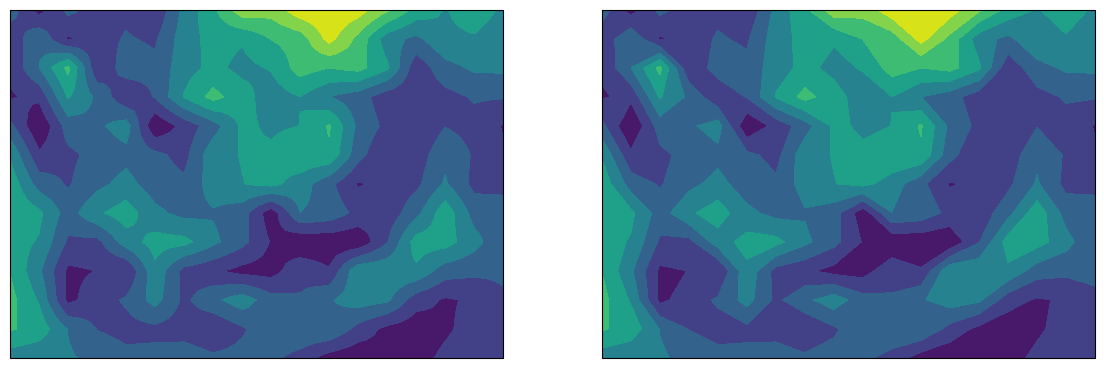

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7), subplot_kw={'projection': ccrs.PlateCarree()})

axs[0].contourf(weather_data.test['wind_speed'].isel(time=0).longitude, weather_data.test['wind_speed'].isel(time=0).latitude, weather_data.test['wind_speed'].isel(time=0).values[0], levels=10)
axs[1].contourf(weather_data.base['wind_speed'].isel(time=0).longitude, weather_data.base['wind_speed'].isel(time=0).latitude, weather_data.base['wind_speed'].isel(time=0).values[1], levels=10)


plt.show()